In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set()
warnings.filterwarnings(action="ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print("Started!")

Started!


In [2]:
gender_columns = ["female_defendant", "female_petitioner", "female_adv_def", "female_adv_pet"]

def gender_to_int(x):
    return int(str(x).split()[0])

def get_year_cases(year):
    fields = ["ddl_case_id", "year", "state_code", "female_defendant", "female_petitioner", "female_adv_def", "female_adv_pet", "disp_name", "date_of_filing", "date_of_decision", "date_first_list",
       "date_last_list", "date_next_list"]
    
    cases = pd.read_csv(f"csv/cases/cases/cases_{year}.csv", usecols=fields) # , nrows=10000
    
    # normalise gender columns to ints (apparently only female_defendant col has strings, but still)
    for gc in gender_columns:
        cases[gc] = cases[gc].apply(gender_to_int)
        # print(cases[gc].unique())

    return cases

In [3]:
state_key = pd.read_csv("csv/keys/keys/cases_state_key.csv")

def get_state_code_to_name(year):
    state_code_to_name = {}
    
    for ind in state_key.index:
        if state_key.year[ind] == year:
            state_code_to_name[state_key.state_code[ind]] = state_key.state_name[ind]
            
    return state_code_to_name

In [4]:
def get_good_disp(cases):
    # might wanna add: , 'bail granted', 'bail refused', 'bail rejected'
    return cases.loc[cases.disp_name.isin(['allowed', 'dismissed', 'convicted', 'plea bargaining', 'reject', 'plead guilty', 'withdrawn', 'acquitted', 'confession', 'settled', 'died'])] # select some cute dispositions


In [5]:
def process_dates_and_filter(cases):
    # print("- Undecided cases:", cases.date_of_decision.isna().sum())
    date_columns = ["date_of_filing", "date_of_decision", "date_first_list", "date_next_list"]
    for date_col in date_columns:
        cases[date_col] = pd.to_datetime(cases[date_col], errors="coerce")

    cases = cases.dropna(subset=date_columns)

    cases.loc[:,"duration"] = (cases.date_of_decision - cases.date_of_filing).dt.days + 1
    # return cases
    return cases.loc[(cases.duration > 0) & (cases.date_of_decision <= pd.to_datetime("2022-12-31"))]

In [6]:
judge_case_key = pd.read_csv("csv/keys/keys/judge_case_merge_key.csv")

def merge_judge_data(cases):
    return pd.merge(cases, judge_case_key, on="ddl_case_id", how="left")

In [7]:
def describe_durations_by_disp(cases):
    for disp_name in cases.disp_name.unique():
        print("\n\n----------------", disp_name, sep="\n")
        print(cases.loc[cases.disp_name == disp_name].duration.describe())

In [8]:
disp_key = pd.read_csv("csv/keys/keys/disp_name_key.csv")

def merge_disp_name(cases, year):
    cases = pd.merge(cases, disp_key[["year", "disp_name", "disp_name_s"]], on=["year", "disp_name"], how="left")
    cases.disp_name = cases.disp_name_s
    return cases.drop(columns="disp_name_s")


----------------------
Beginning 2018 -------
----------------------
- 50% cases were removed due to invalid dates or undecidedness
- Working with 6928805 cases
- Merged dispositions

----------------------
Beginning 2017 -------
----------------------
- 38% cases were removed due to invalid dates or undecidedness
- Working with 8077020 cases
- Merged dispositions

----------------------
Beginning 2016 -------
----------------------
- 31% cases were removed due to invalid dates or undecidedness
- Working with 7833919 cases
- Merged dispositions

----------------------
Beginning 2015 -------
----------------------
- 24% cases were removed due to invalid dates or undecidedness
- Working with 8001609 cases
- Merged dispositions

----------------------
Beginning 2014 -------
----------------------
- 21% cases were removed due to invalid dates or undecidedness
- Working with 7022638 cases
- Merged dispositions


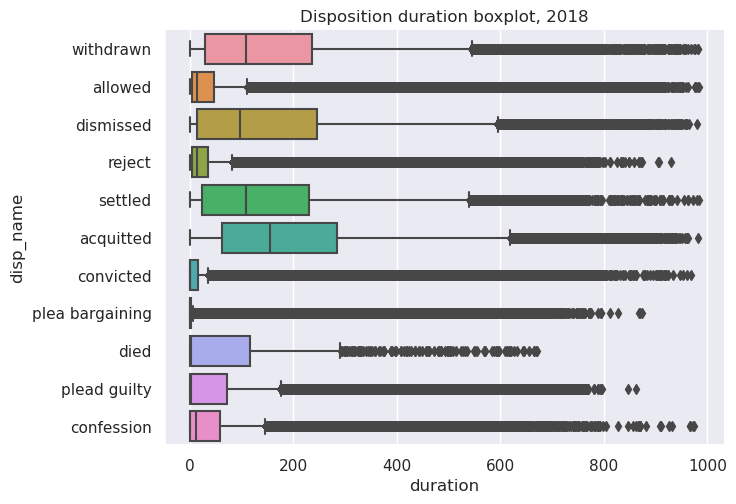

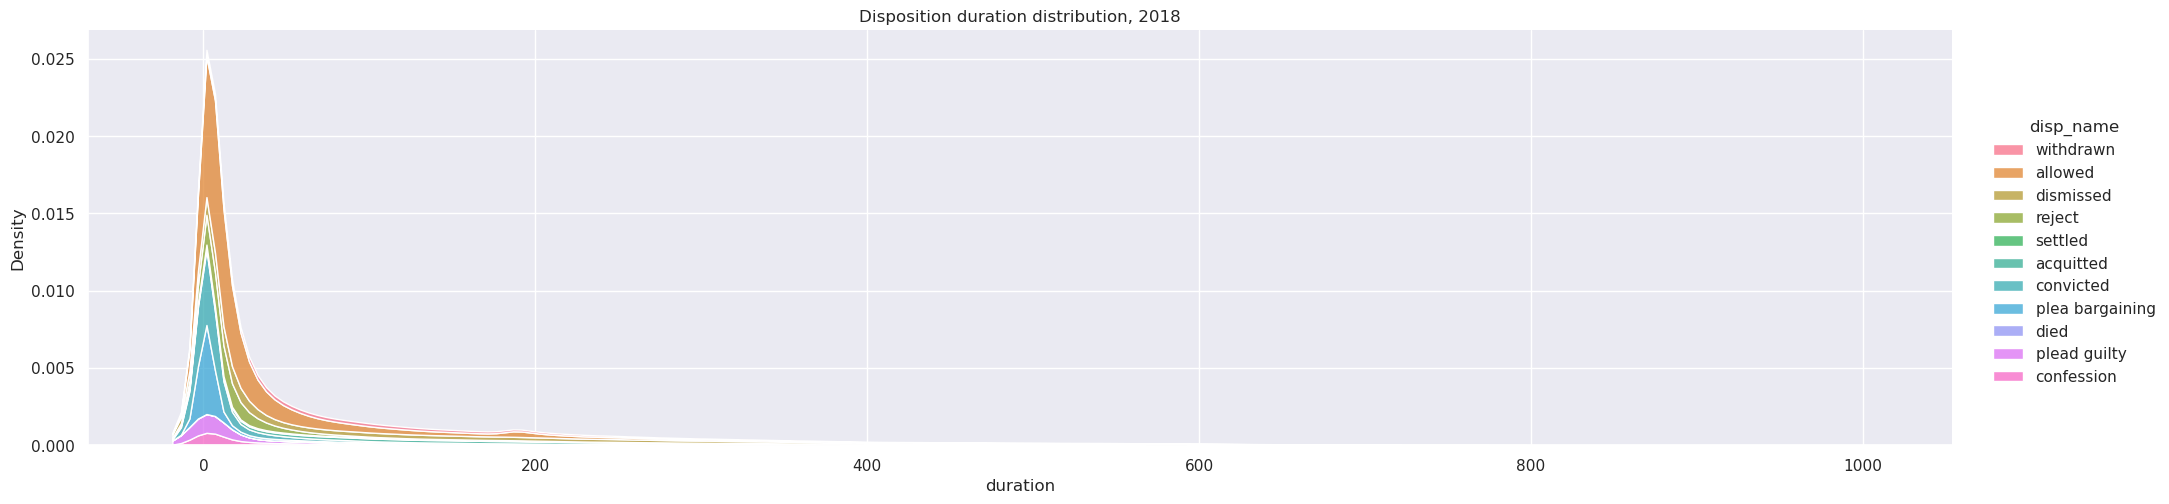

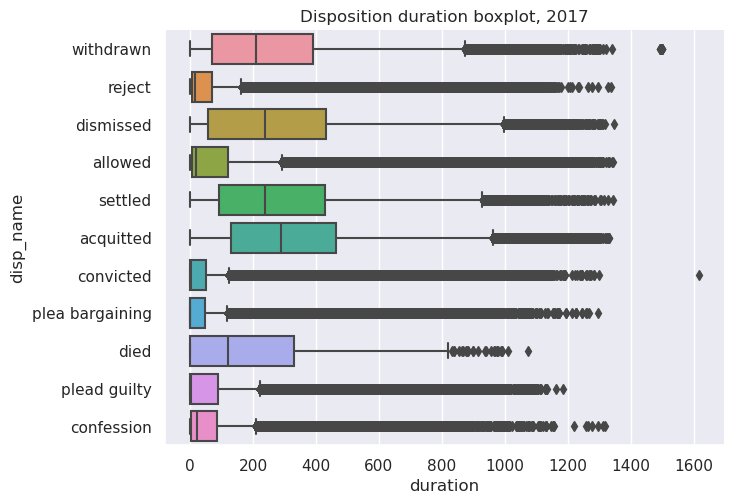

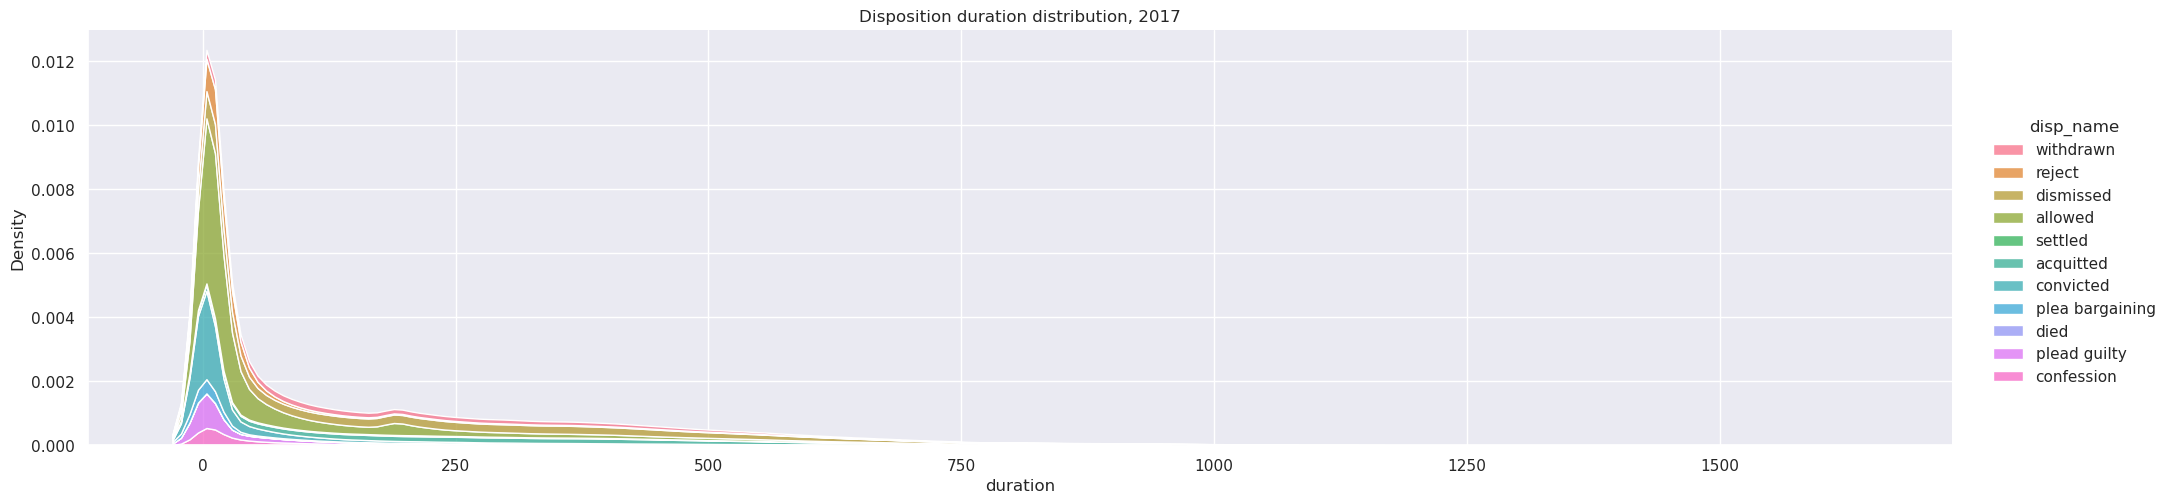

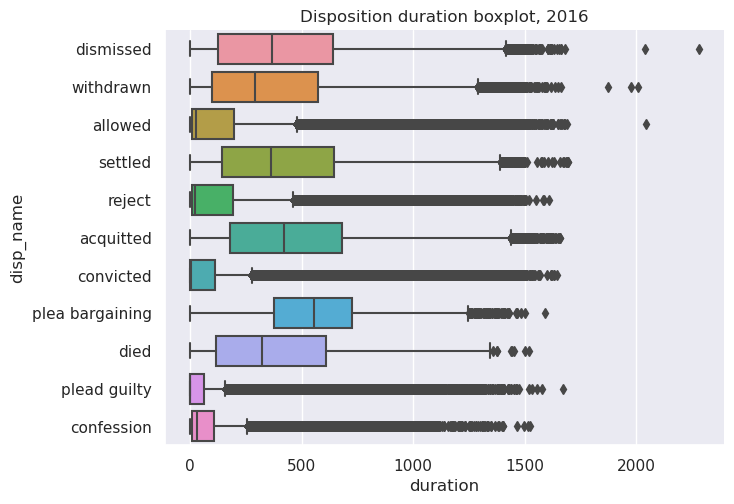

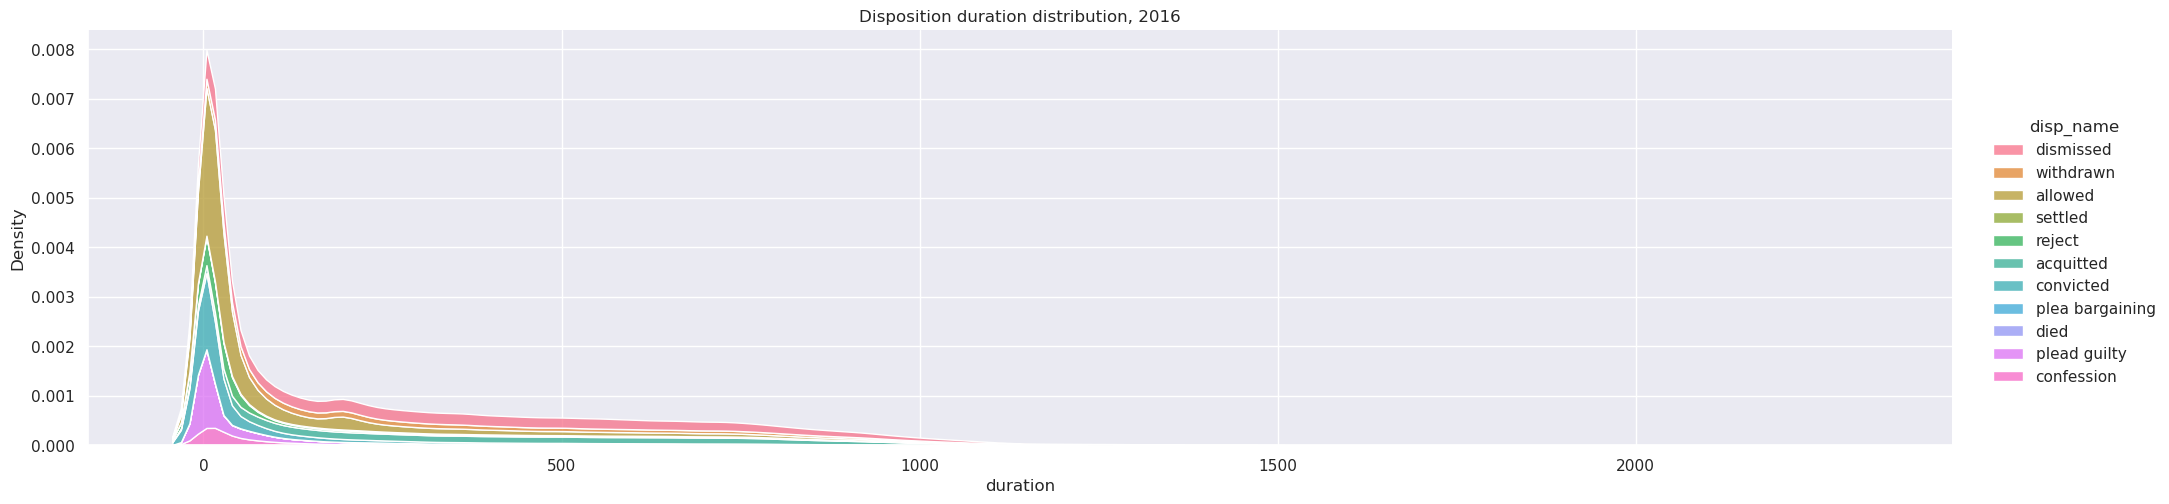

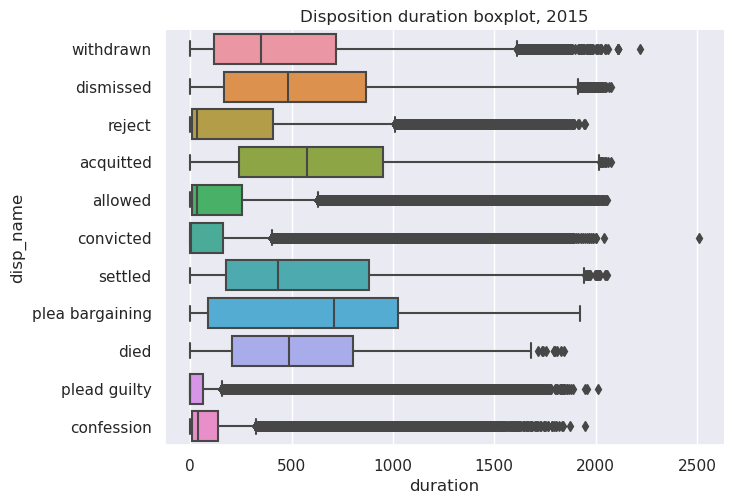

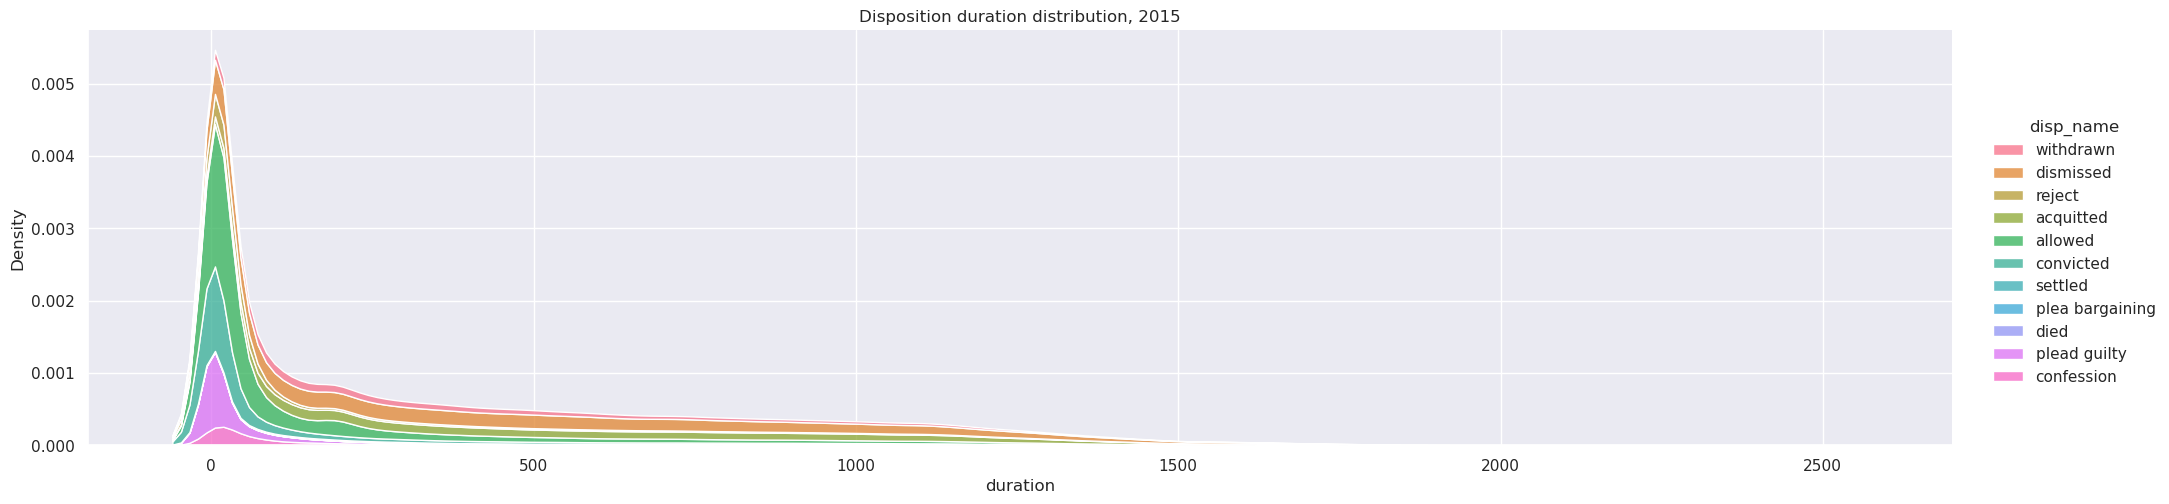

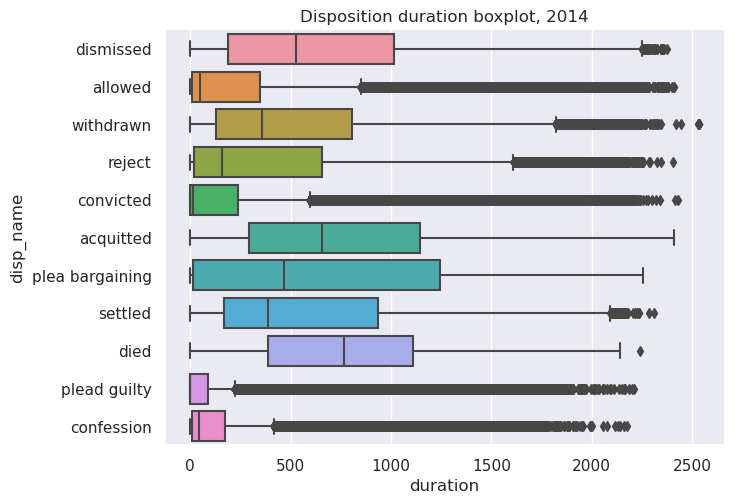

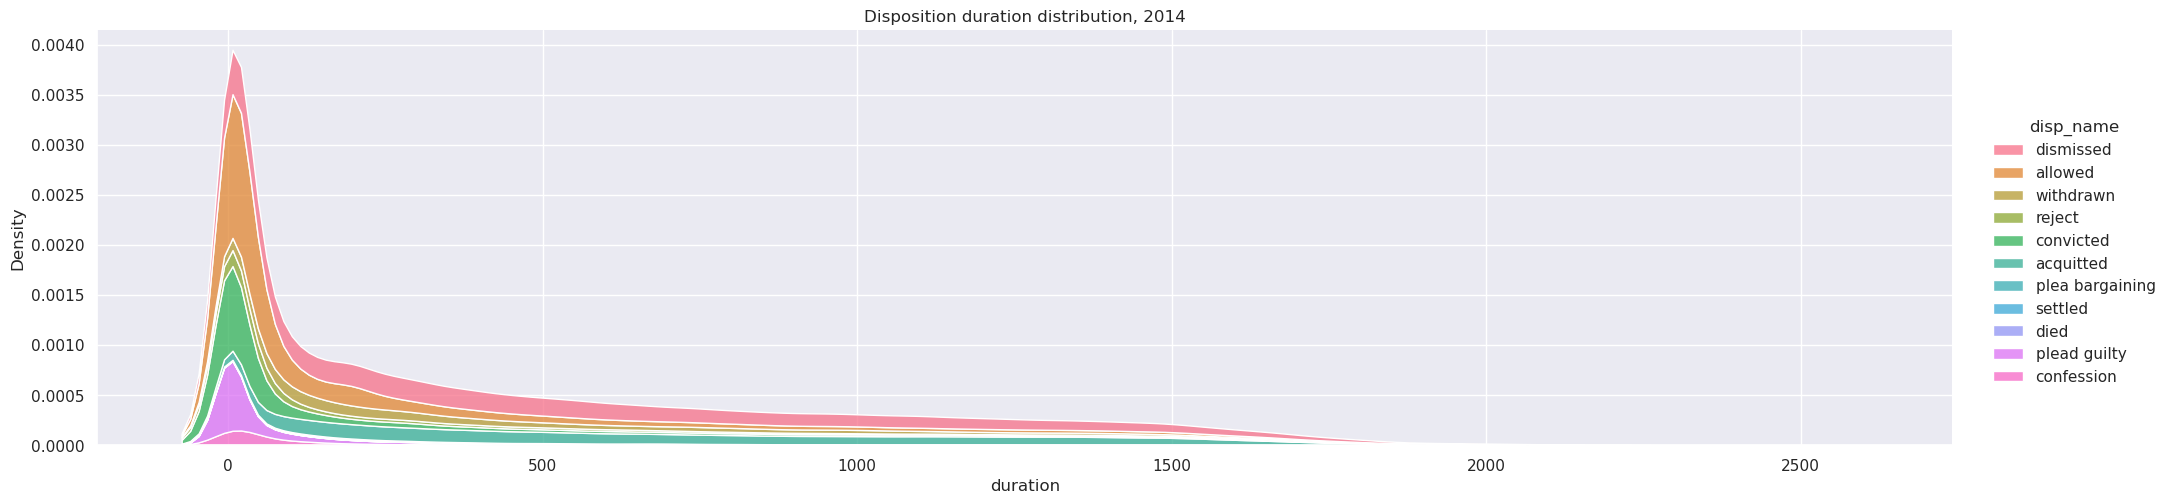

In [9]:
working_year_cases = []
working_year = 2016

for year in range(2018, 2013, -1):
    print("\n----------------------")
    print("Beginning", year, "-------")
    print("----------------------")
    
    cases = get_year_cases(year)
    date_processed_cases = process_dates_and_filter(cases)
    print("- ", round(100 - 100 * (date_processed_cases.shape[0] / cases.shape[0])), "% cases were removed due to invalid dates or undecidedness", sep="")
    print("- Working with", date_processed_cases.shape[0], "cases") 
    cases = merge_disp_name(date_processed_cases, year)
    print("- Merged dispositions")
    cases = get_good_disp(cases)
    # print(cases.head())
    
    if working_year == year:
        working_year_cases = cases.copy()
    
    sns.catplot(x="duration", y="disp_name", data=cases, kind="box", aspect=1.5).set(title=f"Disposition duration boxplot, {year}")
    sns.displot(data=cases, x="duration", hue="disp_name", multiple="stack", kind="kde", aspect=4).set(title=f"Disposition duration distribution, {year}")
    # describe_durations_by_disp(cases)
    
cases = working_year_cases

**Insight:** Over the years, the mean duration of resolved cases decreases.

This might point to the judicial system becoming more efficient over time. However, it cannot be concluded from this data. This is in no small part due to the bias present in our data.

As we consider more recent years, we put an upper bound on the resolution time of the case. Any case which couldn't complete till the last update of the data isn't accounted for. Clearly, more recent years will have more such pending cases, and hence we end up only considering the cases which were decided quicker. 

This is also reflected in the percentage of cases that we dropped from consideration due to their pendency.

**Insight:** *Plead-guilty, confession, convicted,* and *rejected* dispositions have an extremely small median duration.

This is easy to reason, since many of the criminal cases which are brought to the court are for obvious criminals. In these cases, it is very easy to determine that the person is indeed guilty - which may be due to the overbearing evidence against them or they themselves admit to their guilt since it wouldn't be reasonable to fight for innocence.

By merging the available judge data, we notice that quite a few cases have different filing and decision judges. This motivates enquiry into whether there are any significant differences in the two types of cases.

In [10]:
cases = merge_judge_data(cases)

In [11]:
cases_diff_judge = cases.loc[(~cases.ddl_decision_judge_id.isnull()) & (cases.ddl_filing_judge_id != cases.ddl_decision_judge_id)]
cases_same_judge = cases.loc[(~cases.ddl_decision_judge_id.isnull()) & (cases.ddl_filing_judge_id == cases.ddl_decision_judge_id)]

print("Diff:", cases_diff_judge.shape[0], ", Same:", cases_same_judge.shape[0], ", Other Cases:", cases.shape[0] - cases_diff_judge.shape[0] - cases_same_judge.shape[0])

Diff: 200949 , Same: 551916 , Other Cases: 2803408


In [12]:
print(cases_diff_judge.duration.describe())
print("----")
print(cases_same_judge.duration.describe())

count   200949.000
mean       528.077
std        289.108
min          1.000
25%        300.000
50%        536.000
75%        750.000
max       1450.000
Name: duration, dtype: float64
----
count   551916.000
mean        77.169
std        147.744
min          1.000
25%          5.000
50%         15.000
75%         62.000
max       1430.000
Name: duration, dtype: float64


**Insight**: On an average, cases with different filing and decision judges take much, much longer to complete.

This could instead point to the following: for cases which go on for longer, there is a higher chance of the judge being changed in the process. This seems reasonable enough to infer.

We now analyse the impact of states on the judiciary system.

In [13]:
cases = pd.merge(cases, state_key[["year", "state_code", "state_name"]], on=["year", "state_code"], how="left")
cases.head()

# Goa has 1 case, let's drop
# cases = cases.loc[cases.state_name != "Goa"]

print(cases.columns)

Index(['ddl_case_id', 'year', 'state_code', 'female_defendant',
       'female_petitioner', 'female_adv_def', 'female_adv_pet', 'disp_name',
       'date_of_filing', 'date_of_decision', 'date_first_list',
       'date_last_list', 'date_next_list', 'duration', 'ddl_filing_judge_id',
       'ddl_decision_judge_id', 'state_name'],
      dtype='object')


In [14]:
state_duration_means = []

for state_name in cases.state_name.unique():
    duration_mean = cases.loc[cases.state_name == state_name].duration.mean()
    state_duration_means.append({"state_name": state_name, "duration_mean": duration_mean})
    

state_case_agg = pd.DataFrame(state_duration_means)
state_case_agg.sort_values(by="duration_mean", inplace=True)
state_case_agg

,state_name,duration_mean
24,Manipur,79.585
23,Sikkim,121.327
20,Meghalaya,127.456
16,Gujarat,144.246
2,Karnataka,179.839
7,Bihar,191.861
6,Jharkhand,216.092
14,Uttarakhand,221.515
12,Uttar Pradesh,222.482
22,Madhya Pradesh,232.119


In [15]:
judges = pd.read_csv("csv/judges_clean.csv")
judges = pd.merge(judges, state_key[["state_code", "state_name"]], on=["state_code"], how="left")

In [16]:
judges.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,state_name
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
1,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
2,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
3,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
4,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra


In [17]:
state_case_agg["judges"] = 0
state_case_agg["cases"] = 0
state_case_agg["cases/judges"] = 0

for state_name in judges.state_name.unique():
    judge_count = judges.loc[judges.state_name == state_name].shape[0]
    case_count = cases.loc[cases.state_name == state_name].shape[0]
    state_case_agg.loc[state_case_agg.state_name == state_name, ["judges", "cases", "cases/judges"]] = judge_count, case_count, case_count / judge_count

In [18]:
state_case_agg

,state_name,duration_mean,judges,cases,cases/judges
24,Manipur,79.585,1017,7430,7.306
23,Sikkim,121.327,1503,2569,1.709
20,Meghalaya,127.456,1332,1541,1.157
16,Gujarat,144.246,66249,348944,5.267
2,Karnataka,179.839,61335,484708,7.903
7,Bihar,191.861,37116,124328,3.350
6,Jharkhand,216.092,20565,55095,2.679
14,Uttarakhand,221.515,9738,40020,4.110
12,Uttar Pradesh,222.482,126342,349514,2.766
22,Madhya Pradesh,232.119,50661,238385,4.705


In [19]:
# Add population information to the DataFrame

population = {
    "Uttar Pradesh": 199812341,
    "Maharashtra": 112374333,
    "Bihar": 104099452,
    "West Bengal": 91276115,
    "Madhya Pradesh": 72626809,
    "Tamil Nadu": 72147030,
    "Rajasthan": 68548437,
    "Karnataka": 61095297,
    "Gujarat": 60439692,
    "Andhra Pradesh": 49577103,
    "Orissa": 41974219,
    "Telangana": 35003674,
    "Kerala": 33406061,
    "Jharkhand": 32988134,
    "Assam": 31205576,
    "Punjab": 27743338,
    "Chhattisgarh": 25545198,
    "Haryana": 25353081,
    "Jammu and Kashmir": 12541302,
    "Uttarakhand": 10086292,
    "Himachal Pradesh": 6864602,
    "Tripura": 3673917,
    "Meghalaya": 2966889,
    "Manipur": 2721756,
    "Nagaland": 1978502,
    "Goa": 1458545,
    "Arunachal Pradesh": 1383727,
    "Mizoram": 1091014,
    "Sikkim": 607688,
    "Delhi": 16753235,
    "Puducherry": 1244464,
    "Chandigarh": 1054686,
    "Andaman and Nicobar Islands": 380581,
    "DNH at Silvasa": 342853,
    "Diu and Daman": 243247,
    "Lakshadweep": 64429
}

state_case_agg["population"] = 0
state_case_agg = state_case_agg[~state_case_agg.state_name.isin(["Ladakh", "DNH at Silvasa", "Diu and Daman"])]

for state_name in state_case_agg.state_name.unique():
    state_case_agg.loc[state_case_agg.state_name == state_name, "population"] = population[state_name]
    
state_case_agg.head()

,state_name,duration_mean,judges,cases,cases/judges,population
24,Manipur,79.585,1017,7430,7.306,2721756
23,Sikkim,121.327,1503,2569,1.709,607688
20,Meghalaya,127.456,1332,1541,1.157,2966889
16,Gujarat,144.246,66249,348944,5.267,60439692
2,Karnataka,179.839,61335,484708,7.903,61095297


In [20]:
state_case_agg["population/cases"] = state_case_agg.population / state_case_agg.cases
state_case_agg.sort_values(by="population/cases", inplace=True)
state_case_agg

,state_name,duration_mean,judges,cases,cases/judges,population,population/cases
26,Chandigarh,327.462,1260,15376,12.203,1054686,68.593
13,Haryana,238.314,21042,304668,14.479,25353081,83.215
21,Punjab,264.772,17469,273141,15.636,27743338,101.571
2,Karnataka,179.839,61335,484708,7.903,61095297,126.046
25,Delhi,314.927,13464,106918,7.941,16753235,156.692
16,Gujarat,144.246,66249,348944,5.267,60439692,173.207
3,Kerala,318.284,27963,189932,6.792,33406061,175.884
4,Himachal Pradesh,286.208,8235,35466,4.307,6864602,193.554
23,Sikkim,121.327,1503,2569,1.709,607688,236.547
14,Uttarakhand,221.515,9738,40020,4.110,10086292,252.031


<AxesSubplot:>

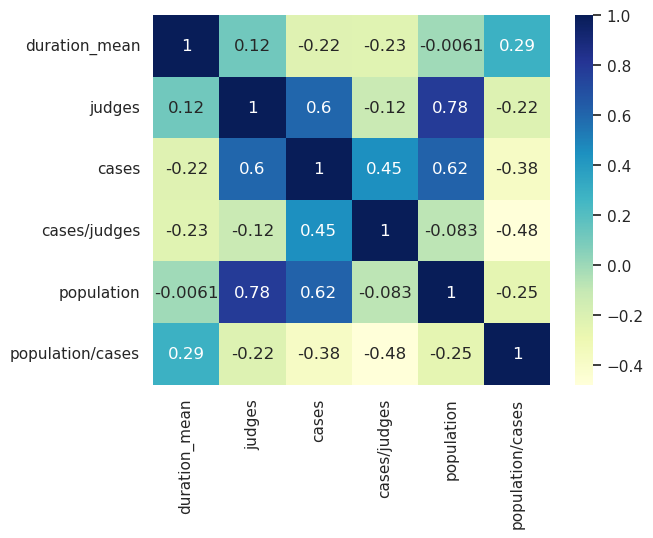

In [21]:
sns.heatmap(state_case_agg.corr(), cmap="YlGnBu", annot=True)

**Insight**: This shows a significant correlation between the population, the number of cases, and the number of judges in a state. This seems expected. The population and the mean duration of cases in a state also seem to be slightly positively correlated.

**Insight**: Interestingly, it also shows a moderate negative correlation between the ratio `cases/judges` and the mean duration of cases. This might seem counter-intuitive at first, since if there are fewer cases per judge, then the judge should be able to get done with them in less time instead of more. 

But there seems to be a plausible explanation.

To venture a guess, this might have to do with [Parkinson's Law](https://en.wikipedia.org/wiki/Parkinson%27s_law). When a judge has fewer cases, they spend more time with the details of each individual case. Alongside, another important factor is that the judge's availability isn't the only factor for deciding the case. More important factors include the time it takes to prepare for the next hearing in light of new evidence or arguments, the bureaucratic grunt-work, etc. So there's only so fast a case can proceed even when a judge has more available time.

However, once the judges have an overbearing amount of load, the duration to close cases will inevitably increase. This is because eventually the judges' availability will be the bottleneck.

We next analyse the judges' metadata themselves, and the effect of states on them.

In [22]:
judges.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,state_name
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
1,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
2,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
3,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
4,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra


Removed 49% judges
count   450810.000
mean       583.965
std        500.405
min          2.000
25%        215.000
50%        462.000
75%        862.000
max       7728.000
Name: duration, dtype: float64


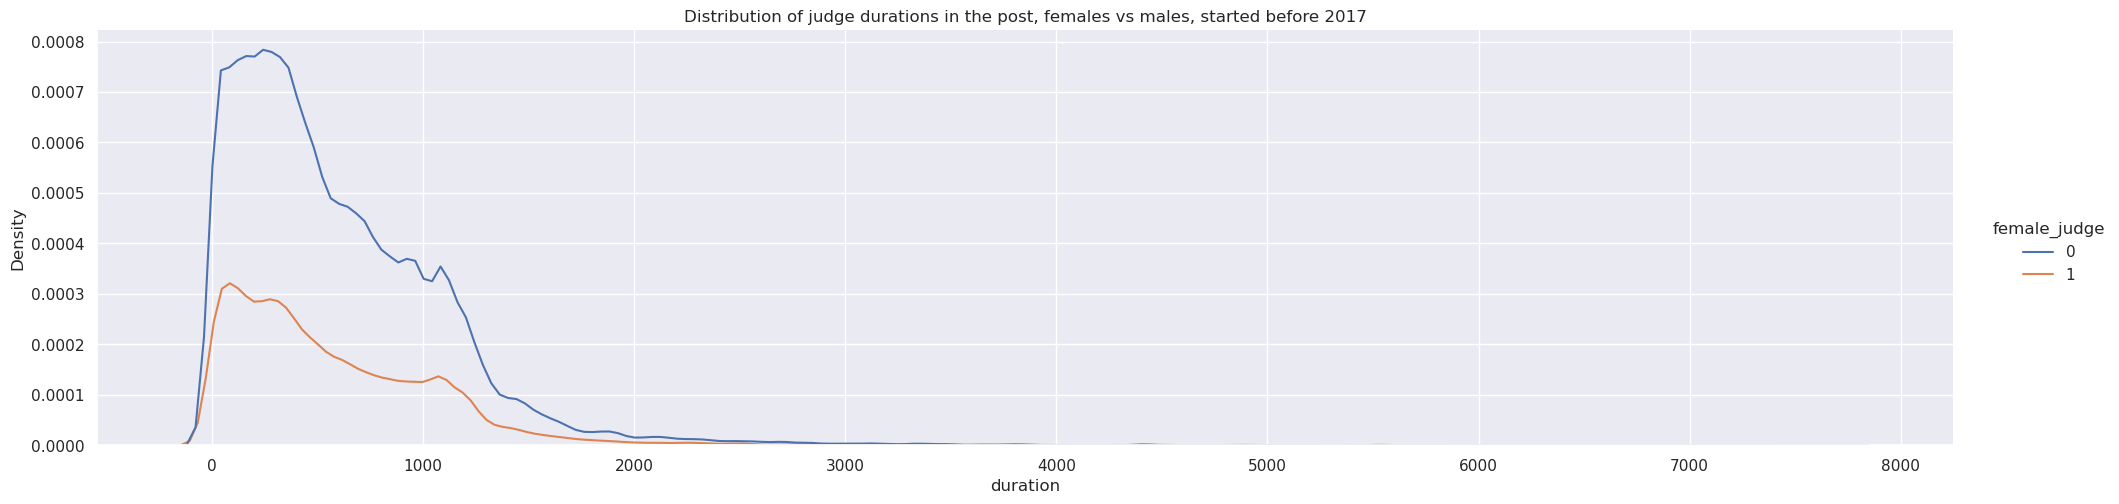

     state_code  male_duration  female_duration  m_-_f_duration  judges  \
0             7        546.920          785.798        -238.877   12105   
9            19        582.625          675.571         -92.946     198   
18           21        535.389          623.271         -87.882     594   
27           25        591.848          679.500         -87.652     495   
36           27        828.545          907.000         -78.455     756   
45            6        680.044          723.373         -43.329    7191   
54           18        697.519          731.000         -33.481    5175   
63            5        659.986          692.854         -32.868    4995   
72            2        615.324          644.303         -28.979   16659   
81            8        653.746          680.362         -26.616   13140   
90           26        740.796          760.800         -20.004    4257   
99           23        804.604          822.430         -17.826   26730   
108           3        52

In [23]:
def analyse_judges(judges):
    init_judge_ct = judges.shape[0]
    
    # filter for only judges with known genders AND started atmost 2016
    judges = judges.copy()[judges.female_judge.notna()]
    judges.female_judge = judges.female_judge.apply(gender_to_int)
    judges = judges.loc[(judges.female_judge == 0) | (judges.female_judge == 1)]
    
    date_columns = ["start_date", "end_date"]
    for dc in date_columns:
        judges[dc] = pd.to_datetime(judges[dc], errors="coerce")
    
    judges["duration"] = (judges.end_date - judges.start_date).dt.days + 1
    judges = judges[(judges.duration >= 1) & (judges.start_date <= pd.to_datetime("01/01/2017"))]
        
    fin_judge_ct = judges.shape[0]
    print("Removed ", round(100 - 100 * fin_judge_ct / init_judge_ct), "% judges", sep="")
    
    print(judges.duration.describe())
    sns.displot(x="duration", hue="female_judge", data=judges, kind="kde", aspect=4).set(title="Distribution of judge durations in the post, females vs males, started before 2017")
    plt.show()
    
    state_judges_data = []
    for state_code in judges.state_code.unique():
        curr_state_judges = judges.loc[judges.state_code == state_code]
        male_duration_mean = curr_state_judges.loc[judges.female_judge == 0].duration.mean()
        female_duration_mean = curr_state_judges.loc[judges.female_judge == 1].duration.mean()
        judge_count = curr_state_judges.shape[0]
        
        data = {"state_code": state_code, "male_duration": male_duration_mean, "female_duration": female_duration_mean, "m_-_f_duration": male_duration_mean - female_duration_mean, "judges": judge_count}
        state_judges_data.append(data)
    
    state_judges = pd.DataFrame(state_judges_data)
    state_judges.sort_values(by="m_-_f_duration", inplace=True)
    state_judges = pd.merge(state_judges, state_key[["state_code", "state_name"]], on=["state_code"], how="left").drop_duplicates()
    print(state_judges)
    
    
    
analyse_judges(judges)

**Insight**: Jharkhand and Sikkim appear to be outliers. On an average, a female judge in Jharkhand stays in her position for ~200 more days than a male judge. This stat almost reverses in the case of Sikkim.

In [24]:
# filter judges for known genders
processed_judges = judges.copy()[judges.female_judge.notna()]
processed_judges.female_judge = processed_judges.female_judge.apply(gender_to_int)

judge_id_to_female = {}
    
for ind in processed_judges.index:
    judge_id_to_female[processed_judges.ddl_judge_id[ind]] = processed_judges.female_judge[ind]

print("Built judge ID to gender map")

Built judge ID to gender map


In [25]:
def merge_case_judge_gender(cases):
    # fill decision judge genders
    cases = cases.copy()
    cases["female_decision_judge"] = pd.Series(dtype='int')
    
    cases = pd.merge(cases, processed_judges[["ddl_judge_id", "female_judge"]], left_on="ddl_decision_judge_id", right_on="ddl_judge_id", how="left")
    
    # for ind in cases.index:
    #     judge_id = cases.ddl_decision_judge_id[ind]
    #     if judge_id in judge_id_to_female:
    #         cases.female_decision_judge[ind] = judge_id_to_female[judge_id]
    
    cases.female_decision_judge = cases.female_judge
    cases = cases.drop(columns=["female_judge"])
    cases = cases.dropna(subset=["female_decision_judge"])
    cases["same_gender"] = cases.female_defendant == cases.female_decision_judge
    return cases
        
    
case_judge_gender = merge_case_judge_gender(cases)
# cases.columns

In [26]:
case_judge_gender.corr()

,year,state_code,female_defendant,female_petitioner,female_adv_def,female_adv_pet,duration,ddl_filing_judge_id,ddl_decision_judge_id,female_decision_judge,ddl_judge_id,same_gender
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_code,NaN,1.000,0.016,-0.094,-0.012,-0.112,-0.077,0.973,0.973,-0.063,0.973,0.032
female_defendant,NaN,0.016,1.000,-0.496,-0.007,-0.368,0.360,0.002,-0.008,0.024,-0.008,0.601
female_petitioner,NaN,-0.094,-0.496,1.000,-0.101,0.391,-0.154,-0.073,-0.066,0.024,-0.066,-0.303
female_adv_def,NaN,-0.012,-0.007,-0.101,1.000,0.157,-0.032,-0.002,-0.003,-0.084,-0.003,0.055
female_adv_pet,NaN,-0.112,-0.368,0.391,0.157,1.000,-0.191,-0.094,-0.090,0.007,-0.090,-0.178
duration,NaN,-0.077,0.360,-0.154,-0.032,-0.191,1.000,-0.086,-0.096,0.060,-0.096,0.180
ddl_filing_judge_id,NaN,0.973,0.002,-0.073,-0.002,-0.094,-0.086,1.000,1.000,-0.109,1.000,0.021
ddl_decision_judge_id,NaN,0.973,-0.008,-0.066,-0.003,-0.090,-0.096,1.000,1.000,-0.107,1.000,0.016
female_decision_judge,NaN,-0.063,0.024,0.024,-0.084,0.007,0.060,-0.109,-0.107,1.000,-0.107,-0.053


We check if there's bias regarding gender in assignment of judges to defendants.

In [27]:
print(case_judge_gender.loc[(case_judge_gender.female_defendant == 0) & (case_judge_gender.female_decision_judge == 0)].shape[0] / case_judge_gender.loc[case_judge_gender.female_defendant == 0].shape[0])
print(case_judge_gender.loc[(case_judge_gender.female_defendant == 1) & (case_judge_gender.female_decision_judge == 0)].shape[0] / case_judge_gender.loc[case_judge_gender.female_defendant == 1].shape[0])

0.6890116500786877
0.6935483870967742


**Insight:** There seems to be no such bias, as in the odds of assignment of a female decision judge is the same regardless of the defendant gender. This might point to an impartial / automated system of allocating cases to judges.

In [28]:
case_judge_gender = get_good_disp(case_judge_gender)

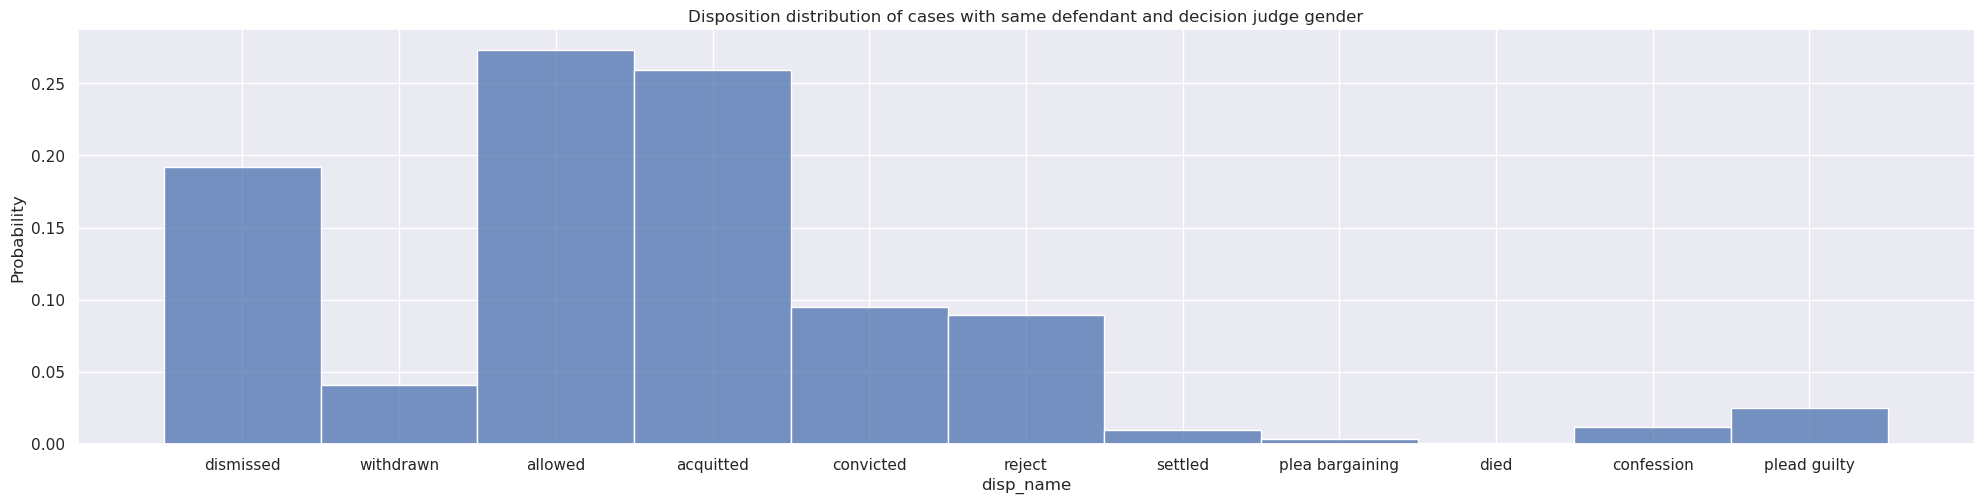

In [29]:
sns.displot(case_judge_gender.loc[case_judge_gender.female_decision_judge == case_judge_gender.female_defendant], x="disp_name", aspect=4, stat="probability").set(title="Disposition distribution of cases with same defendant and decision judge gender")

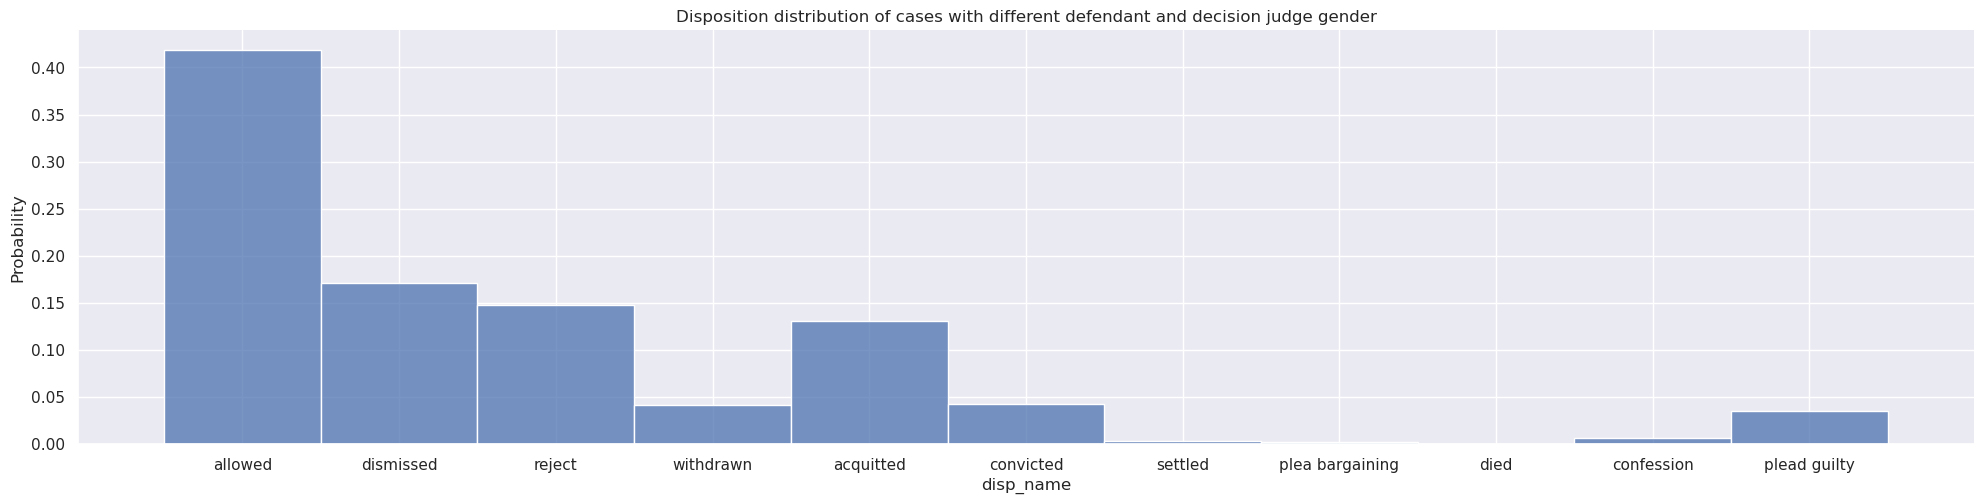

In [30]:
sns.displot(case_judge_gender.loc[case_judge_gender.female_decision_judge != case_judge_gender.female_defendant], x="disp_name", aspect=4, stat="probability").set(title="Disposition distribution of cases with different defendant and decision judge gender")

**Insight:** The above two plots show that there is a significant difference in the distribution of dispositions among cases with different defendant and decision judge genders compared to those with the same. For example, the more than 40% cases are decided as 'allowed' when their genders are different, This number is closer to 26% when the genders are the same.

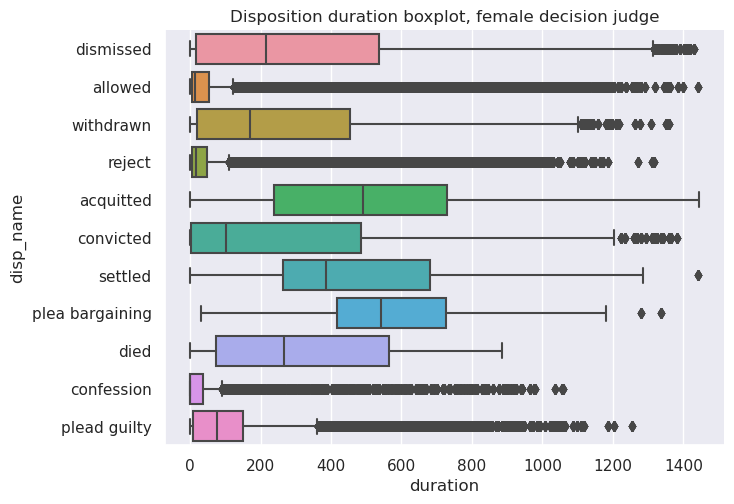

In [31]:
sns.catplot(x="duration", y="disp_name", data=case_judge_gender.loc[case_judge_gender.female_decision_judge == 1], kind="box", aspect=1.5).set(title=f"Disposition duration boxplot, female decision judge")

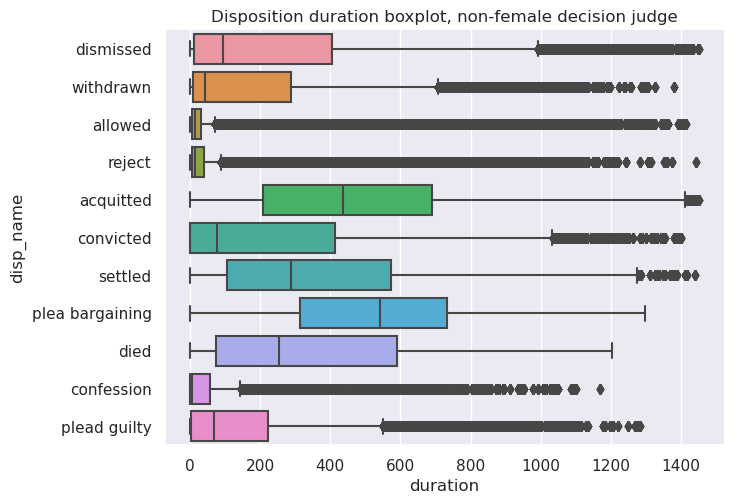

In [32]:
sns.catplot(x="duration", y="disp_name", data=case_judge_gender.loc[case_judge_gender.female_decision_judge == 0], kind="box", aspect=1.5).set(title=f"Disposition duration boxplot, non-female decision judge")

In [33]:
case_judge_gender.loc[case_judge_gender.female_decision_judge == 0].duration.describe()

count   4874382.000
mean        183.126
std         271.119
min           1.000
25%           8.000
50%          27.000
75%         283.000
max        1450.000
Name: duration, dtype: float64

In [34]:
case_judge_gender.loc[case_judge_gender.female_decision_judge == 1].duration.describe()

count   1580193.000
mean        257.192
std         303.585
min           1.000
25%          11.000
50%          99.000
75%         467.000
max        1443.000
Name: duration, dtype: float64

**Insight:** Cases with a female decision judge take much longer to complete. This is not specific to a single disposition either. As apparent from the boxplot of duration of cases segregated by their disposition, the median duration (along with the quartiles) of almost every disposition individually is smaller in the case of non-female judge.